### imports

In [1]:
import gc
import os
import pickle
import random
import time
from collections import Counter, defaultdict
from functools import partial
from pathlib import Path
from psutil import cpu_count

import librosa
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, MultiStepLR
from fastprogress import master_bar, progress_bar
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torchvision.models as models

In [2]:
torch.cuda.is_available()
torch.cuda.set_device(0)

### utils

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)  
    np.random.seed(seed)
    torch.manual_seed(seed)     
    torch.cuda.manual_seed(seed)  
    torch.backends.cudnn.deterministic = True 

SEED = 2019
seed_everything(SEED)

In [4]:
N_JOBS = cpu_count()
print(N_JOBS)
os.environ['MKL_NUM_THREADS'] = str(N_JOBS)  
os.environ['OMP_NUM_THREADS'] = str(N_JOBS)
DataLoader = partial(DataLoader, num_workers=N_JOBS)  

56


In [5]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
# lwlrap( label-weighted label-ranking average precision)
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class

### dataset

In [6]:
dataset_dir = Path('/media/ky02/dcase2019-data/task2')
preprocessed_dir = Path('./fat2019_prep_mels1') # 2s 4s 4s1
print(os.listdir(preprocessed_dir))

['mels_train_noisy.pkl', 'trn_noisy_best50s.csv', 'mels_trn_noisy_best50s.pkl', 'mels_test.pkl', 'mels_train_curated.pkl']


In [7]:
csvs = {
    'train_curated': dataset_dir / 'train_curated.csv',
    'train_noisy': dataset_dir / 'train_noisy.csv',
    'sample_submission': dataset_dir / 'sample_submission.csv',
}

dataset = {
    'train_curated': dataset_dir / 'train_curated',
    'train_noisy': dataset_dir / 'train_noisy',
    'test': dataset_dir / 'test',
}

mels = {
    'train_curated': preprocessed_dir / 'mels_train_curated.pkl',
    'train_noisy': preprocessed_dir / 'mels_train_noisy.pkl', # 'mels_trn_noisy_best50s.pkl'
    'test': preprocessed_dir / 'mels_test.pkl',  # NOTE: this data doesn't work at 2nd stage
}

In [8]:
# tarin is curated+noisy label data 
train_curated = pd.read_csv(csvs['train_curated'])
train_noisy = pd.read_csv(csvs['train_noisy'])
train_df = pd.concat([train_curated, train_noisy],sort=True,ignore_index=True)
train_df.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [9]:
test_df = pd.read_csv(csvs['sample_submission'])
test_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0012633b.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,001ed5f1.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00294be0.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,003fde7a.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
labels = test_df.columns[1:].tolist()
# labels

In [11]:
num_classes = len(labels)
num_classes

80

In [12]:
# train label
y_train = np.zeros((len(train_df), num_classes)).astype(int)
for i, row in enumerate(train_df['labels'].str.split(',')):
    for label in row:
        idx = labels.index(label)
        y_train[i, idx] = 1

y_train.shape

(24785, 80)

In [13]:
with open(mels['train_curated'], 'rb') as curated, open(mels['train_noisy'], 'rb') as noisy:
    x_train = pickle.load(curated)
    x_train.extend(pickle.load(noisy))

with open(mels['test'], 'rb') as test:
    x_test = pickle.load(test)
    
len(x_train), len(x_test)

(24785, 1120)

In [14]:
class FATTrainDataset(Dataset):
    def __init__(self, mels, labels, transforms):
        super().__init__()
        self.mels = mels
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.mels)
    
    def __getitem__(self, idx):
        # crop 1sec
        image = Image.fromarray(self.mels[idx], mode='RGB')        
        time_dim, base_dim = image.size
        crop = random.randint(0, time_dim - 1*base_dim)
        image = image.crop([crop, 0, crop + 1*base_dim, base_dim])  # 随机crop 到（128,128,3）
        image = self.transforms(image).div_(255)  # 归一化
        
        label = self.labels[idx]
        label = torch.from_numpy(label).float()
        
        return image, label

In [15]:
class FATTestDataset(Dataset):
    def __init__(self, fnames, mels, transforms, tta=5):
        super().__init__()
        self.fnames = fnames
        self.mels = mels
        self.transforms = transforms
        self.tta = tta
        
    def __len__(self):
        return len(self.fnames) * self.tta
    
    def __getitem__(self, idx):
        new_idx = idx % len(self.fnames)
        
        image = Image.fromarray(self.mels[new_idx], mode='RGB')
        time_dim, base_dim = image.size
        crop = random.randint(0, time_dim - 1*base_dim)
        image = image.crop([crop, 0, crop + 1*base_dim, base_dim])
        image = self.transforms(image).div_(255)

        fname = self.fnames[new_idx]
        
        return image, fname

### model

In [16]:
import torchvision.models as models


transforms_dict = {
    'train': transforms.Compose([
#        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
#        transforms.Resize(299),
#         transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
    ]),
}



### viggish cnn

In [17]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x


In [18]:
# cnn_8
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=512),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.mean(x, dim=3)
        x, _ = torch.max(x, dim=2)
        x = self.fc(x)
        return x
# Classifier(num_classes=num_classes)


### models in image field

In [20]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [21]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet34":
        """ Resnet34
        """
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_type = 'inception' # 'resnet18' # 'inception'
model_ft, input_size = initialize_model(model_type, num_classes, False, use_pretrained=False)

# print(model_ft)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [22]:
# mixup   https://arxiv.org/pdf/1710.09412.pdf
def mixup_data(x, y, alpha=1.0, use_cuda=True):

    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)  # B分布
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index,:]
    mixed_y = lam * y + (1 - lam) * y[index]
    return mixed_x, mixed_y
#     y_a, y_b = y, y[index]
#     return mixed_x, y_a, y_b, lam

# 对loss进行混合 
def mixup_criterion(y_a, y_b, lam):
    return lambda criterion, pred: lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

### loss function toward noisy labels

In [23]:
# loss function parameters setup
pos_weight=0.7
reed_beta=0.7
m_loss= 0.8
q_loss= 0.7

In [24]:
# tf.nn.weighted_cross_entropy_with_logits 
def weighted_BCEWithLogits(pos_weight):
    def weighted_cross_entropy_with_logits(logits, targets):   # y_pred ,y_true
        return (targets * -logits.sigmoid().log() * pos_weight + (1 - targets) * -(1 - logits.sigmoid()).log()).mean()
    return weighted_cross_entropy_with_logits


# loss function, update target with predictions
def crossentropy_reed_wrap(_beta):
    def crossentropy_reed_core(y_pred, y_true):
        """
        This loss function is proposed in:
        Reed et al. "Training Deep Neural Networks on Noisy Labels with Bootstrapping", 2014
        :param y_true:
        :param y_pred:
        :return:
        """

        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.clamp(y_pred, 1e-7, 1)

        # (1) dynamically update the targets based on the current state of the model: bootstrapped target tensor
        # use predicted class proba directly to generate regression targets
        y_true_update = _beta * y_true + (1 - _beta) * y_pred

        # (2) compute loss as always
        _loss = -y_true_update*torch.log(y_pred)-(1-y_true_update)*torch.log(1-y_pred)
        _loss = _loss.mean()
        # _loss=F.binary_cross_entropy(y_pred, y_true_update)
        return _loss
    return crossentropy_reed_core


# dcase18 task2, by cochlear.ai.
def crossentropy_max_wrap(_m):
    def crossentropy_max_core(logits, targets):
        """
        This function is based on the one proposed in
        Il-Young Jeong and Hyungui Lim, "AUDIO TAGGING SYSTEM FOR DCASE 2018: FOCUSING ON LABEL NOISE,
         DATA AUGMENTATION AND ITS EFFICIENT LEARNING", Tech Report, DCASE 2018
        https://github.com/finejuly/dcase2018_task2_cochlearai
        :param y_true:
        :param y_pred:
        :return:
        """
        _loss = torch.mean(targets * -logits.sigmoid().log() + (1 - targets) * -(1 - logits.sigmoid()).log(),dim=-1)
        # threshold
        t_m = torch.max(_loss) * _m
        t_m=torch.ones(len(_loss))*t_m
        _mask_m =1- torch.le(t_m, _loss.cpu())
        _loss = (_loss.cpu() * _mask_m.float()).mean().cuda()
        return _loss
    return crossentropy_max_core

def lq_loss_wrap(_q):
    def lq_loss_core(y_pred, y_true):
        """
        This loss function is proposed in:
         Zhilu Zhang and Mert R. Sabuncu, "Generalized Cross Entropy Loss for Training Deep Neural Networks with
         Noisy Labels", 2018
        https://arxiv.org/pdf/1805.07836.pdf
        :param y_true:
        :param y_pred:
        :return:
        """
        eps = 1e-7
        _loss = y_pred * y_true
        
        # compute the Lq loss between the one-hot encoded label and the prediction
        _loss = (1 - (_loss + eps) ** _q) / _q

        return _loss.mean()
    return lq_loss_core

### train

In [25]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
import pickle
logs = []
test_fold=[]

def train_model(x_train, y_train, train_transforms, model_path, num_epochs = 5,\
                batch_size = 32, test_batch_size = 64, N_fold=5):
    
    lr = 1e-3
    eta_min = 1e-7
    t_max = 20
    
    num_classes = y_train.shape[1]
    
    # CV 
    kfold = KFold(n_splits = N_fold, shuffle = True, random_state= SEED)
    for ifold, (train_index, valid_index) in enumerate(kfold.split(x_train, y_train)): 
        print("--------------------------------------------")
        print("Fold %d"%(ifold))   
        trn_loss = []
        val_loss = []
        val_lwlrap = []
        lr_log = []
      
        x_trn = [x_train[i] for i in train_index]
        x_val = [x_train[i] for i in valid_index]
        y_trn = y_train[train_index]
        y_val = y_train[valid_index]        
            
        train_dataset = FATTrainDataset(x_trn, y_trn, train_transforms)
        valid_dataset = FATTrainDataset(x_val, y_val, train_transforms)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=test_batch_size, shuffle=False)
        
#         model_ft, input_size = initialize_model(model_type, num_classes, False, use_pretrained=False)
#         model = model_ft.cuda()
        
        # model_cnn
        model = Classifier(num_classes=num_classes).cuda()
     
        # reload
#         if model_path and False:
#             model.load_state_dict(torch.load(model_path + str(ifold) + '.pt'))
#         model.cuda()

        # loss function
#         criterion = nn.BCEWithLogitsLoss().cuda()   # sigmoid
        criterion=weighted_BCEWithLogits(pos_weight)
#         criterion=crossentropy_max_wrap(m_loss)
#         criterion=crossentropy_reed_wrap(reed_beta)

  
        optimizer = Adam(params=model.parameters(), lr=lr, amsgrad=False)
        scheduler = CosineAnnealingLR(optimizer, T_max=t_max, eta_min=eta_min)

        best_epoch = -1
        best_lwlrap = 0.
        mb = master_bar(range(num_epochs))
        for epoch in mb:
            start_time = time.time()
            model.train()
            avg_loss = 0.

            for x_batch, y_batch in progress_bar(train_loader, parent=mb):
                # generate mixed inputs, two one-hot label vectors and mixing coefficient
                if mixup_on:
                    x_batch, y_batch = mixup_data(x_batch, y_batch, alpha=1, use_cuda=True)

                if model_type != 'inception':
                    preds = model(x_batch.cuda())
                    loss = criterion(preds, y_batch.cuda())
                else:
                    outputs, aux_outputs = model(x_batch.cuda())
                    loss1 = criterion(outputs, y_batch.cuda())
                    loss2 = criterion(aux_outputs, y_batch.cuda())
                    loss = loss1 + 0.4*loss2
                  
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                avg_loss += loss.item() / len(train_loader)

            # validation
            model.eval()
            valid_preds = np.zeros((len(x_val), num_classes))
            avg_val_loss = 0.

            for i, (x_batch, y_batch) in enumerate(valid_loader):
                preds = model(x_batch.cuda()).detach()
                loss = criterion(preds, y_batch.cuda())

                preds = torch.sigmoid(preds)
                valid_preds[i * test_batch_size: (i+1) * test_batch_size] = preds.cpu().numpy()

                avg_val_loss += loss.item() / len(valid_loader)

            score, weight = calculate_per_class_lwlrap(y_val, valid_preds)
            lwlrap = (score * weight).sum()

            scheduler.step() # for CosineAnnealingLR, CLR
    #         scheduler.step(avg_val_loss) # for reduceLR
            for param_group in optimizer.param_groups:
                lr_temp = param_group['lr']
            lr_log.append(lr_temp)

            if (epoch + 1) % 1 == 0:
                elapsed = time.time() - start_time
                print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  val_lwlrap: {lwlrap:.6f}  time: {elapsed:.0f}s')
                trn_loss.append(avg_loss)
                val_loss.append(avg_val_loss)
                val_lwlrap.append(lwlrap)

            if lwlrap > best_lwlrap:
                best_epoch = epoch + 1
                best_lwlrap = lwlrap
                best_train_loss = avg_loss
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), model_path + str(ifold) + '.pt')
                torch.save(model,model_path+str(ifold)+'_all.pt')
        test_fold.append({
        'best_epoch': best_epoch,
        'best_lwlrap': best_lwlrap,
        'best_train_loss':best_train_loss,
        'best_val_loss':best_val_loss})
        print(test_fold)

        logs.append({
            'best_epoch': best_epoch,
            'best_lwlrap': best_lwlrap,
            'best_train_loss':best_train_loss,
            'best_val_loss':best_val_loss,
            'trn_loss':trn_loss,
            'val_loss':val_loss,
            'val_lwlrap':val_lwlrap,
            'lr_log':lr_log
        })
    return(logs)

In [26]:
num_epochs = 100
batch_size = 64
test_batch_size = 64
N_fold = 5
lr_method = 'cosine' # 'CLR'
augmentation = 'flip'
mixup_on = True
model_type='cnn'
model_path = './weight/weight_wqk/weight_loss_net_2s_%(m)s_%(lr)s_%(aug)s'% \
{'m':model_type, 'lr':lr_method, 'aug':augmentation}
output_path = './submission/submission_wqk/submission_loss_net_2s_%(m)s_%(lr)s_%(aug)s'%\
{'m':model_type, 'lr':lr_method, 'aug':augmentation}

result = train_model(x_train, y_train, transforms_dict['train'], model_path,
                     num_epochs, batch_size, test_batch_size, N_fold)

--------------------------------------------
Fold 0


Epoch 1 - avg_train_loss: 0.2234  avg_val_loss: 0.0587  val_lwlrap: 0.077753  time: 84s


/home/kuaiyu/anaconda3/envs/pytorch1.0/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Classifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kuaiyu/anaconda3/envs/pytorch1.0/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 2 - avg_train_loss: 0.0579  avg_val_loss: 0.0570  val_lwlrap: 0.117564  time: 85s
Epoch 3 - avg_train_loss: 0.0563  avg_val_loss: 0.0593  val_lwlrap: 0.086321  time: 85s
Epoch 4 - avg_train_loss: 0.0548  avg_val_loss: 0.0652  val_lwlrap: 0.080249  time: 86s
Epoch 5 - avg_train_loss: 0.0539  avg_val_loss: 0.1142  val_lwlrap: 0.070861  time: 86s
Epoch 6 - avg_train_loss: 0.0531  avg_val_loss: 0.0618  val_lwlrap: 0.083415  time: 88s
Epoch 7 - avg_train_loss: 0.0527  avg_val_loss: 0.0703  val_lwlrap: 0.078158  time: 87s
Epoch 8 - avg_train_loss: 0.0520  avg_val_loss: 0.0864  val_lwlrap: 0.082363  time: 88s
Epoch 9 - avg_train_loss: 0.0514  avg_val_loss: 0.0723  val_lwlrap: 0.085710  time: 88s
Epoch 10 - avg_train_loss: 0.0509  avg_val_loss: 0.0776  val_lwlrap: 0.079667  time: 88s
Epoch 11 - avg_train_loss: 0.0504  avg_val_loss: 0.0864  val_lwlrap: 0.090541  time: 90s
Epoch 12 - avg_train_loss: 0.0501  avg_val_loss: 0.0849  val_lwlrap: 0.084322  time: 88s
Epoch 13 - avg_train_loss: 0.

Epoch 95 - avg_train_loss: 0.0405  avg_val_loss: 0.0556  val_lwlrap: 0.260055  time: 89s
Epoch 96 - avg_train_loss: 0.0410  avg_val_loss: 0.0473  val_lwlrap: 0.375463  time: 90s
Epoch 97 - avg_train_loss: 0.0408  avg_val_loss: 0.0343  val_lwlrap: 0.585940  time: 89s
Epoch 98 - avg_train_loss: 0.0404  avg_val_loss: 0.0344  val_lwlrap: 0.584935  time: 89s
Epoch 99 - avg_train_loss: 0.0403  avg_val_loss: 0.0333  val_lwlrap: 0.604440  time: 89s
Epoch 100 - avg_train_loss: 0.0401  avg_val_loss: 0.0332  val_lwlrap: 0.602437  time: 90s
[{'best_epoch': 99, 'best_lwlrap': 0.6044397694925042, 'best_train_loss': 0.04028811244474306, 'best_val_loss': 0.033305847491973496}]
--------------------------------------------
Fold 1


Epoch 1 - avg_train_loss: 0.2245  avg_val_loss: 0.0576  val_lwlrap: 0.101422  time: 90s
Epoch 2 - avg_train_loss: 0.0577  avg_val_loss: 0.0601  val_lwlrap: 0.080722  time: 90s
Epoch 3 - avg_train_loss: 0.0562  avg_val_loss: 0.0819  val_lwlrap: 0.074067  time: 90s
Epoch 4 - avg_train_loss: 0.0546  avg_val_loss: 0.0683  val_lwlrap: 0.081195  time: 87s
Epoch 5 - avg_train_loss: 0.0537  avg_val_loss: 0.0670  val_lwlrap: 0.074406  time: 90s
Epoch 6 - avg_train_loss: 0.0530  avg_val_loss: 0.0687  val_lwlrap: 0.086965  time: 93s
Epoch 7 - avg_train_loss: 0.0525  avg_val_loss: 0.0758  val_lwlrap: 0.077678  time: 89s
Epoch 8 - avg_train_loss: 0.0516  avg_val_loss: 0.0770  val_lwlrap: 0.097941  time: 88s
Epoch 9 - avg_train_loss: 0.0513  avg_val_loss: 0.0567  val_lwlrap: 0.162854  time: 90s
Epoch 10 - avg_train_loss: 0.0507  avg_val_loss: 0.0830  val_lwlrap: 0.093076  time: 92s
Epoch 11 - avg_train_loss: 0.0503  avg_val_loss: 0.0662  val_lwlrap: 0.096282  time: 91s
Epoch 12 - avg_train_loss: 0.0

Epoch 94 - avg_train_loss: 0.0407  avg_val_loss: 0.0693  val_lwlrap: 0.098364  time: 92s
Epoch 95 - avg_train_loss: 0.0405  avg_val_loss: 0.0613  val_lwlrap: 0.284771  time: 91s
Epoch 96 - avg_train_loss: 0.0406  avg_val_loss: 0.0491  val_lwlrap: 0.365943  time: 91s
Epoch 97 - avg_train_loss: 0.0398  avg_val_loss: 0.0581  val_lwlrap: 0.341738  time: 93s
Epoch 98 - avg_train_loss: 0.0402  avg_val_loss: 0.0338  val_lwlrap: 0.589791  time: 90s
Epoch 99 - avg_train_loss: 0.0406  avg_val_loss: 0.0339  val_lwlrap: 0.590401  time: 93s
Epoch 100 - avg_train_loss: 0.0405  avg_val_loss: 0.0336  val_lwlrap: 0.595912  time: 93s
[{'best_epoch': 99, 'best_lwlrap': 0.6044397694925042, 'best_train_loss': 0.04028811244474306, 'best_val_loss': 0.033305847491973496}, {'best_epoch': 100, 'best_lwlrap': 0.5959124827631661, 'best_train_loss': 0.040483273337444926, 'best_val_loss': 0.033555500233211584}]
--------------------------------------------
Fold 2


Epoch 1 - avg_train_loss: 0.2189  avg_val_loss: 0.0571  val_lwlrap: 0.119349  time: 92s
Epoch 2 - avg_train_loss: 0.0575  avg_val_loss: 0.0559  val_lwlrap: 0.136925  time: 93s
Epoch 3 - avg_train_loss: 0.0561  avg_val_loss: 0.1880  val_lwlrap: 0.074407  time: 93s
Epoch 4 - avg_train_loss: 0.0545  avg_val_loss: 0.0866  val_lwlrap: 0.069999  time: 91s
Epoch 5 - avg_train_loss: 0.0539  avg_val_loss: 0.0748  val_lwlrap: 0.070035  time: 92s
Epoch 6 - avg_train_loss: 0.0531  avg_val_loss: 0.0629  val_lwlrap: 0.103718  time: 92s
Epoch 7 - avg_train_loss: 0.0524  avg_val_loss: 0.0850  val_lwlrap: 0.079049  time: 92s
Epoch 8 - avg_train_loss: 0.0516  avg_val_loss: 0.0780  val_lwlrap: 0.072399  time: 94s
Epoch 9 - avg_train_loss: 0.0513  avg_val_loss: 0.1609  val_lwlrap: 0.073066  time: 92s
Epoch 10 - avg_train_loss: 0.0506  avg_val_loss: 0.0618  val_lwlrap: 0.132057  time: 93s
Epoch 11 - avg_train_loss: 0.0502  avg_val_loss: 0.0987  val_lwlrap: 0.096237  time: 93s
Epoch 12 - avg_train_loss: 0.0

Epoch 94 - avg_train_loss: 0.0408  avg_val_loss: 0.0530  val_lwlrap: 0.309283  time: 90s
Epoch 95 - avg_train_loss: 0.0406  avg_val_loss: 0.0452  val_lwlrap: 0.397093  time: 90s
Epoch 96 - avg_train_loss: 0.0405  avg_val_loss: 0.0377  val_lwlrap: 0.531926  time: 90s
Epoch 97 - avg_train_loss: 0.0406  avg_val_loss: 0.0359  val_lwlrap: 0.556312  time: 91s
Epoch 98 - avg_train_loss: 0.0394  avg_val_loss: 0.0375  val_lwlrap: 0.525830  time: 90s
Epoch 99 - avg_train_loss: 0.0408  avg_val_loss: 0.0338  val_lwlrap: 0.587264  time: 92s
Epoch 100 - avg_train_loss: 0.0403  avg_val_loss: 0.0338  val_lwlrap: 0.589571  time: 91s
[{'best_epoch': 99, 'best_lwlrap': 0.6044397694925042, 'best_train_loss': 0.04028811244474306, 'best_val_loss': 0.033305847491973496}, {'best_epoch': 100, 'best_lwlrap': 0.5959124827631661, 'best_train_loss': 0.040483273337444926, 'best_val_loss': 0.033555500233211584}, {'best_epoch': 100, 'best_lwlrap': 0.5895709666633523, 'best_train_loss': 0.04031892438088694, 'best_val_

Epoch 1 - avg_train_loss: 0.2243  avg_val_loss: 0.0582  val_lwlrap: 0.098954  time: 92s
Epoch 2 - avg_train_loss: 0.0577  avg_val_loss: 0.0598  val_lwlrap: 0.069832  time: 90s
Epoch 3 - avg_train_loss: 0.0557  avg_val_loss: 0.1635  val_lwlrap: 0.066187  time: 90s
Epoch 4 - avg_train_loss: 0.0545  avg_val_loss: 0.0642  val_lwlrap: 0.089400  time: 90s
Epoch 5 - avg_train_loss: 0.0537  avg_val_loss: 0.1803  val_lwlrap: 0.073410  time: 90s
Epoch 6 - avg_train_loss: 0.0530  avg_val_loss: 0.0603  val_lwlrap: 0.104809  time: 91s
Epoch 7 - avg_train_loss: 0.0524  avg_val_loss: 0.0978  val_lwlrap: 0.077647  time: 91s
Epoch 8 - avg_train_loss: 0.0516  avg_val_loss: 0.0874  val_lwlrap: 0.082856  time: 88s
Epoch 9 - avg_train_loss: 0.0511  avg_val_loss: 0.0606  val_lwlrap: 0.122596  time: 89s
Epoch 10 - avg_train_loss: 0.0506  avg_val_loss: 0.1360  val_lwlrap: 0.075680  time: 91s
Epoch 11 - avg_train_loss: 0.0502  avg_val_loss: 0.0865  val_lwlrap: 0.086762  time: 91s
Epoch 12 - avg_train_loss: 0.0

Epoch 94 - avg_train_loss: 0.0416  avg_val_loss: 0.0678  val_lwlrap: 0.236047  time: 91s
Epoch 95 - avg_train_loss: 0.0414  avg_val_loss: 0.0410  val_lwlrap: 0.473083  time: 94s
Epoch 96 - avg_train_loss: 0.0410  avg_val_loss: 0.0505  val_lwlrap: 0.386856  time: 90s
Epoch 97 - avg_train_loss: 0.0407  avg_val_loss: 0.0397  val_lwlrap: 0.491934  time: 91s
Epoch 98 - avg_train_loss: 0.0405  avg_val_loss: 0.0378  val_lwlrap: 0.529994  time: 91s
Epoch 99 - avg_train_loss: 0.0402  avg_val_loss: 0.0345  val_lwlrap: 0.584503  time: 91s
Epoch 100 - avg_train_loss: 0.0401  avg_val_loss: 0.0345  val_lwlrap: 0.585754  time: 91s
[{'best_epoch': 99, 'best_lwlrap': 0.6044397694925042, 'best_train_loss': 0.04028811244474306, 'best_val_loss': 0.033305847491973496}, {'best_epoch': 100, 'best_lwlrap': 0.5959124827631661, 'best_train_loss': 0.040483273337444926, 'best_val_loss': 0.033555500233211584}, {'best_epoch': 100, 'best_lwlrap': 0.5895709666633523, 'best_train_loss': 0.04031892438088694, 'best_val_

Epoch 1 - avg_train_loss: 0.2216  avg_val_loss: 0.0579  val_lwlrap: 0.106111  time: 91s
Epoch 2 - avg_train_loss: 0.0577  avg_val_loss: 0.0616  val_lwlrap: 0.080950  time: 91s
Epoch 3 - avg_train_loss: 0.0557  avg_val_loss: 0.0724  val_lwlrap: 0.077129  time: 91s
Epoch 4 - avg_train_loss: 0.0544  avg_val_loss: 0.0663  val_lwlrap: 0.076851  time: 91s
Epoch 5 - avg_train_loss: 0.0538  avg_val_loss: 0.1017  val_lwlrap: 0.071081  time: 91s
Epoch 6 - avg_train_loss: 0.0532  avg_val_loss: 0.1316  val_lwlrap: 0.072247  time: 91s
Epoch 7 - avg_train_loss: 0.0527  avg_val_loss: 0.0798  val_lwlrap: 0.083462  time: 91s
Epoch 8 - avg_train_loss: 0.0519  avg_val_loss: 0.0734  val_lwlrap: 0.074619  time: 91s
Epoch 9 - avg_train_loss: 0.0514  avg_val_loss: 0.0592  val_lwlrap: 0.144583  time: 91s
Epoch 10 - avg_train_loss: 0.0513  avg_val_loss: 0.0627  val_lwlrap: 0.114596  time: 91s
Epoch 11 - avg_train_loss: 0.0504  avg_val_loss: 0.0894  val_lwlrap: 0.079628  time: 93s
Epoch 12 - avg_train_loss: 0.0

Epoch 94 - avg_train_loss: 0.0410  avg_val_loss: 0.0662  val_lwlrap: 0.229001  time: 93s
Epoch 95 - avg_train_loss: 0.0411  avg_val_loss: 0.0523  val_lwlrap: 0.357218  time: 93s
Epoch 96 - avg_train_loss: 0.0412  avg_val_loss: 0.0398  val_lwlrap: 0.487816  time: 92s
Epoch 97 - avg_train_loss: 0.0408  avg_val_loss: 0.0403  val_lwlrap: 0.493361  time: 92s
Epoch 98 - avg_train_loss: 0.0406  avg_val_loss: 0.0345  val_lwlrap: 0.586611  time: 92s
Epoch 99 - avg_train_loss: 0.0403  avg_val_loss: 0.0339  val_lwlrap: 0.599961  time: 92s
Epoch 100 - avg_train_loss: 0.0404  avg_val_loss: 0.0338  val_lwlrap: 0.598878  time: 93s
[{'best_epoch': 99, 'best_lwlrap': 0.6044397694925042, 'best_train_loss': 0.04028811244474306, 'best_val_loss': 0.033305847491973496}, {'best_epoch': 100, 'best_lwlrap': 0.5959124827631661, 'best_train_loss': 0.040483273337444926, 'best_val_loss': 0.033555500233211584}, {'best_epoch': 100, 'best_lwlrap': 0.5895709666633523, 'best_train_loss': 0.04031892438088694, 'best_val_

In [27]:
print('best_epoch:',[result[i]['best_epoch'] for i in range(N_fold)])
print('best_lwlrap:',['{:.5f}'.format(result[i]['best_lwlrap']) for i in range(N_fold)])
print('best_trn_loss:',['{:.5f}'.format(result[i]['best_train_loss']) for i in range(N_fold)])
print('best_val_loss:',['{:.5f}'.format(result[i]['best_val_loss']) for i in range(N_fold)])

best_epoch: [99, 100, 100, 100, 99]
best_lwlrap: ['0.60444', '0.59591', '0.58957', '0.58575', '0.59996']
best_trn_loss: ['0.04029', '0.04048', '0.04032', '0.04012', '0.04034']
best_val_loss: ['0.03331', '0.03356', '0.03378', '0.03449', '0.03389']


--------------------------------------------
Fold 0


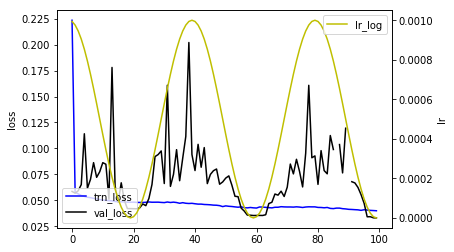

--------------------------------------------
Fold 1


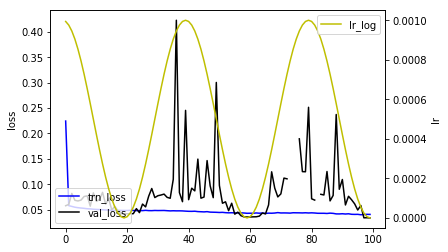

--------------------------------------------
Fold 2


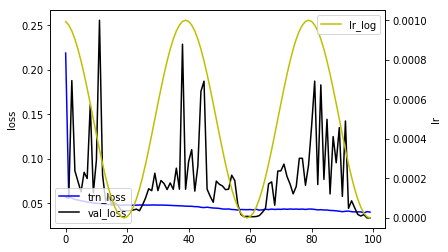

--------------------------------------------
Fold 3


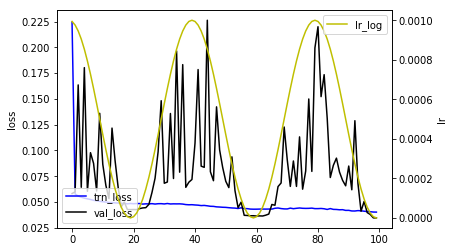

--------------------------------------------
Fold 4


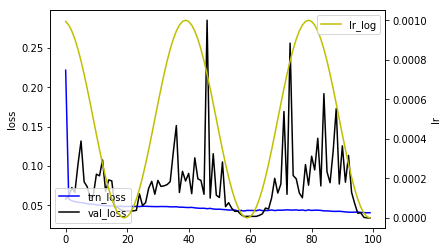

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.title("train loss, validation loss")
for i in range(N_fold):
    print("--------------------------------------------")
    print("Fold %d"%(i))
    fig, ax1 = plt.subplots()
    ax1.plot(result[i]['trn_loss'], label='trn_loss', color='b')
    ax1.plot(result[i]['val_loss'], label='val_loss', color='k')
    ax1.set_ylabel('loss', color='k')
    ax1.legend(loc='lower left')
    # ax1.ylim((0,1.))
    ax2 = ax1.twinx()
    ax2.plot(result[i]['lr_log'], label='lr_log', color='y')
    ax2.set_ylabel('lr', color = 'k')
    ax2.legend(loc='upper right')

    plt.show()

--------------------------------------------
Fold 0


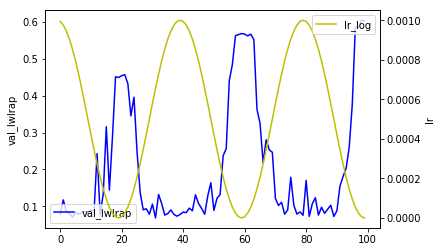

--------------------------------------------
Fold 1


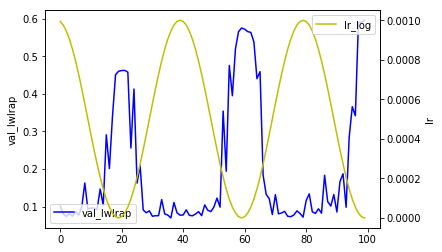

--------------------------------------------
Fold 2


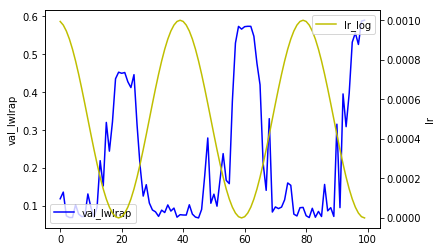

--------------------------------------------
Fold 3


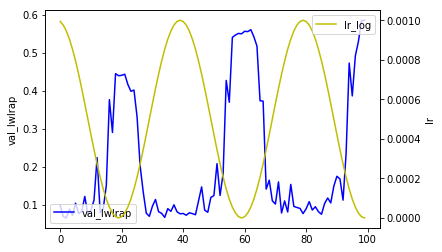

--------------------------------------------
Fold 4


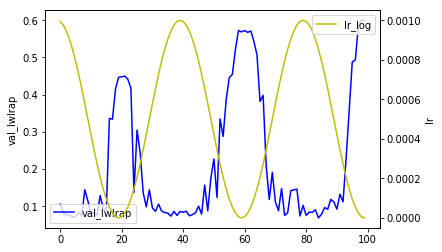

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(N_fold):
    print("--------------------------------------------")
    print("Fold %d"%(i))
    fig, ax1 = plt.subplots()
    ax1.plot(result[i]['val_lwlrap'], label='val_lwlrap', color='b')
    ax1.set_ylabel('val_lwlrap', color='k')
    ax1.legend(loc='lower left')
    # ax1.ylim((0,1.))
    ax2 = ax1.twinx()
    ax2.plot(result[i]['lr_log'], label='lr_log', color='y')
    ax2.set_ylabel('lr', color = 'k')
    ax2.legend(loc='upper right')

    plt.show()

### predict

In [30]:
def predict_model(test_fnames, x_test, test_transforms, model_path, num_classes, tta=5):
    batch_size = 32

    test_dataset = FATTestDataset(test_fnames, x_test, test_transforms, tta=tta)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#     model_ft, input_size = initialize_model(model_type, num_classes, False, use_pretrained=False)
#     model = model_ft
    model = Classifier(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.cuda()
    model.eval()

    all_outputs, all_fnames = [], []

    pb = progress_bar(test_loader)
    for images, fnames in pb:
        preds = torch.sigmoid(model(images.cuda()).detach())
        all_outputs.append(preds.cpu().numpy())
        all_fnames.extend(fnames)

    test_preds = pd.DataFrame(data=np.concatenate(all_outputs),
                              index=all_fnames,
                              columns=map(str, range(num_classes)))
    test_preds = test_preds.groupby(level=0).mean()

    return test_preds

In [31]:
# torch.cuda.set_device(0)
pred_avg = []
for ifold in range(N_fold):
    pre_model = model_path + str(ifold) + '.pt'
    csv_path = output_path + str(ifold) + '.csv'
    test_preds = predict_model(test_df['fname'], x_test, transforms_dict['test'], pre_model, num_classes)
    test_df[labels] = test_preds.values
    test_df.to_csv(csv_path, index=False)
    pred_avg.append(test_preds)

test_df[labels] = sum([pred_avg[i].values for i in range(N_fold)]) / (N_fold)
test_df.to_csv(output_path + '_avg.csv', index=False)


In [32]:
test_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,0.000618,0.000070,0.000113,0.000516,0.000419,0.001393,0.001412,0.001864,0.000934,...,0.000688,0.000107,0.000608,0.000288,0.001555,0.000127,0.027440,0.007028,0.001633,0.000503
1,0012633b.wav,0.093617,0.001612,0.003748,0.002678,0.002551,0.007520,0.023409,0.003045,0.003020,...,0.002202,0.007225,0.000666,0.007602,0.002641,0.009977,0.004725,0.006930,0.008398,0.078262
2,001ed5f1.wav,0.001872,0.000689,0.000219,0.001330,0.002813,0.001920,0.000562,0.008253,0.004200,...,0.002469,0.003275,0.001339,0.003031,0.003149,0.002302,0.000597,0.001470,0.001100,0.001055
3,00294be0.wav,0.000297,0.000026,0.000268,0.000147,0.002353,0.000023,0.000137,0.000311,0.000402,...,0.000326,0.000220,0.000293,0.003645,0.000260,0.000208,0.015343,0.002721,0.000019,0.026091
4,003fde7a.wav,0.000247,0.002408,0.000541,0.000752,0.001157,0.000839,0.001222,0.001421,0.604102,...,0.000752,0.000430,0.001158,0.001919,0.000473,0.000282,0.000896,0.000468,0.000903,0.000843


In [ ]:
# 清除GPU存储
torch.cuda.empty_cache()